# Lab 1: Machine Learning Pipelines and Grid Search

---

How to Use This Notebook

---

**Recommended Setup**

- For the best experience, **run this notebook on [Google Colab](https://colab.research.google.com/)**—especially if your local machine is slow.  

- In Colab, **enable GPU support** by going to:  

  `Runtime > Change runtime type > Hardware accelerator > GPU`

**Homework Tasks**

 - Homework tasks are clearly marked throughout the notebook in the following format:

   > ---

   > <span style="color:red"><b>TASK X</b> - [<i>some text</i>]:</span>

   > ---

   > ```Your code ....```

   > ---

   > *End of Task X.*

 - For each task:

   - **Complete the code** where indicated.

   - **Upload the required results** from each task to **Homework 1 – Code** on [NextIlearn](https://nextilearn.dsv.su.se).

 - Once you've finished all the tasks:

   Submit your **entire completed notebook (including your code!)** to **Homework 1 – Notebook** on [NextIlearn](https://nextilearn.dsv.su.se).

**Important:**  

Your submission will **only be graded if both files** (code + notebook) are uploaded **before the deadline**. Late submissions are **not accepted**, regardless of technical issues like bad internet connection.

---




This lab will cover various ensemble learning methods covered in the lectures, such as boosting, bagging, and stacking, together with the scikit-learn pipeline. We will tackle the fetal health classification problem using random forest and XGBoost for better performances. We will also learn how to integrate preprocessing and training processes into one pipeline to re-use the whole process easier. The objective of this lab is to get a concept of a whole machine learning pipeline from feature engineering to model selection and lead to a final model.

This lab will mainly focus on:
- Learn how to preprocess and oversample imbalanced datasets.
- Learn how to use the basic random forest, Adaboost, and XGBoost.
- Learn how to use grid search (recap on DAMI) and randomized search.
- Learn how to use the scikit-learn pipeline to construct a complete and reusable preprocessing cycle.

Our goal is to find out the best ensemble model for our dataset. We need to split the dataset into two parts: training and validation sets. Then we test parameter options and eventually choose one best model and compare their test performance.

We will use the [fetal health classification](https://www.kaggle.com/andrewmvd/fetal-health-classification) data from Kaggle. The reduction of child mortality is reflected in several of the United Nations' Sustainable Development Goals and is a crucial indicator of human progress. The UN expects that by 2030, countries end preventable deaths of newborns and children under five years of age, with all countries aiming to reduce under‑5 mortality to at least as low as 25 per 1,000 live births.

Parallel to the notion of child mortality is of course maternal mortality, which accounts for 295 000 deaths during and following pregnancy and childbirth (as of 2017). The vast majority of these deaths (94%) occurred in low-resource settings, and most could have been prevented.

In light of what was mentioned above, Cardiotocograms (CTGs) are a simple and cost-accessible option to assess fetal health, allowing healthcare professionals to take action in order to prevent child and maternal mortality. The equipment itself works by sending ultrasound pulses and reading its response, thus shedding light on fetal heart rate (FHR), fetal movements, uterine contractions, and more.

This dataset contains 2126 records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetricians into three classes:

- Normal: 1
- Suspect: 2
- Pathological: 3

We will first try to apply ensemble models and eventually integrate grid search and pipeline to create an automated evaluation process to find the best model.

### 1. Data exploration

Let's locate the dataset anywhere you want in your local and load it using pd.read_csv. The dataset can be downloaded [here](https://www.kaggle.com/andrewmvd/fetal-health-classification). This time, we will return to pandas DataFrame!

In [1]:
import pandas as pd
import numpy as np
import imblearn # install if you don't have it
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Create a DataFrame
data = pd.read_csv("fetal_health.csv")

In [3]:
# head
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


**Duplicates**: The first thing we need to do is to separate features and labels. However, before that, let's check if the data has some duplicated rows.

In [4]:
# Check for duplicates in data
data.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2121    False
2122    False
2123    False
2124    False
2125    False
Length: 2126, dtype: bool

In [5]:
# How many duplicates
data.duplicated().sum()

np.int64(13)

In [6]:
# drop_duplicates
data_dropped = data.drop_duplicates()

In [7]:
# Check dropped datapoints and compare to before dropping duplicates
data_dropped

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


In [8]:
data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


**Features/labels split**: We can choose the columns from the dataframe and create a new variable X.
- what would be our label?
- how could we only choose the columns?

In [9]:
# Features
X = data_dropped.iloc[:, :-1]
# Labels
y = data_dropped["fetal_health"].astype(int) # Pandas series shares some functions with NumPy!

In [10]:
# X.head
X.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0


In [11]:
# y.head
y.head()

0    2
1    1
2    1
3    1
4    1
Name: fetal_health, dtype: int64

In [12]:
# describe - Basic statistics
X.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
count,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,...,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000
mean,133.304780,0.003188,0.009517,0.004387,0.001901,0.000003,0.000159,46.993848,1.335021,9.795078,...,70.535258,93.564600,164.099858,4.077142,0.325603,137.454330,134.599621,138.089446,18.907241,0.318504
std,9.837451,0.003871,0.046804,0.002941,0.002966,0.000057,0.000592,17.177782,0.884368,18.337073,...,39.007706,29.562269,17.945175,2.951664,0.707771,16.402026,15.610422,14.478957,29.038766,0.611075
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.000000,...,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.000000,...,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000
50%,133.000000,0.002000,0.000000,0.005000,0.000000,0.000000,0.000000,49.000000,1.200000,0.000000,...,68.000000,93.000000,162.000000,4.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.000000,...,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.000000,...,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000


Today, our focus is to learn about ensemble methods, so we would not focus on many data exploration strategies, but let's try to investigate a few things. First, let's check if the labels are balanced or not using seaborn.
- [Useful seaborn functions](https://seaborn.pydata.org/tutorial/function_overview.html)

In [13]:
import seaborn as sns

<Axes: xlabel='fetal_health', ylabel='count'>

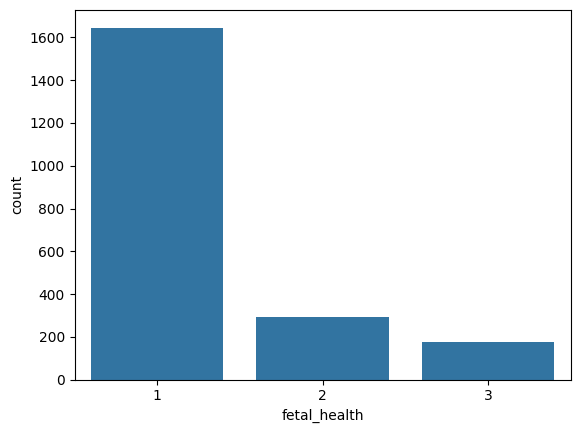

In [ ]:
# countplot - check the proportion visually
sns.countplot(x=y) # looks a bit irritating because before we stated the variable x. But in this case x is a parameter of the seaborn function

In [15]:
# series.value counts - check the proportion
y.value_counts()

fetal_health
1    1646
2     292
3     175
Name: count, dtype: int64

In [16]:
# proportion
y.value_counts() / len(y)

fetal_health
1    0.778987
2    0.138192
3    0.082821
Name: count, dtype: float64

It is natural that the normal cases are most common. It might lead to higher accuracy too, as label 1 keeps about 78% of the whole dataset. However, to make a robust model that does not have any relationship with the distribution the dataset typically has, we may need to consider it so the model should not be biased towards the normal cases.

In [17]:
# isna - Missing data check
X.isna()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2122,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2123,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2124,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
X.isna().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

**Duplicates**: Would there be any rows identical to each other?

In [19]:
X.duplicated().sum()

np.int64(2)

Would it be better to remove these conflicting instances? In this case we need to align the labels too.

In [20]:
X_dropped = X[~X.duplicated()]
y_dropped = y[~X.duplicated()]

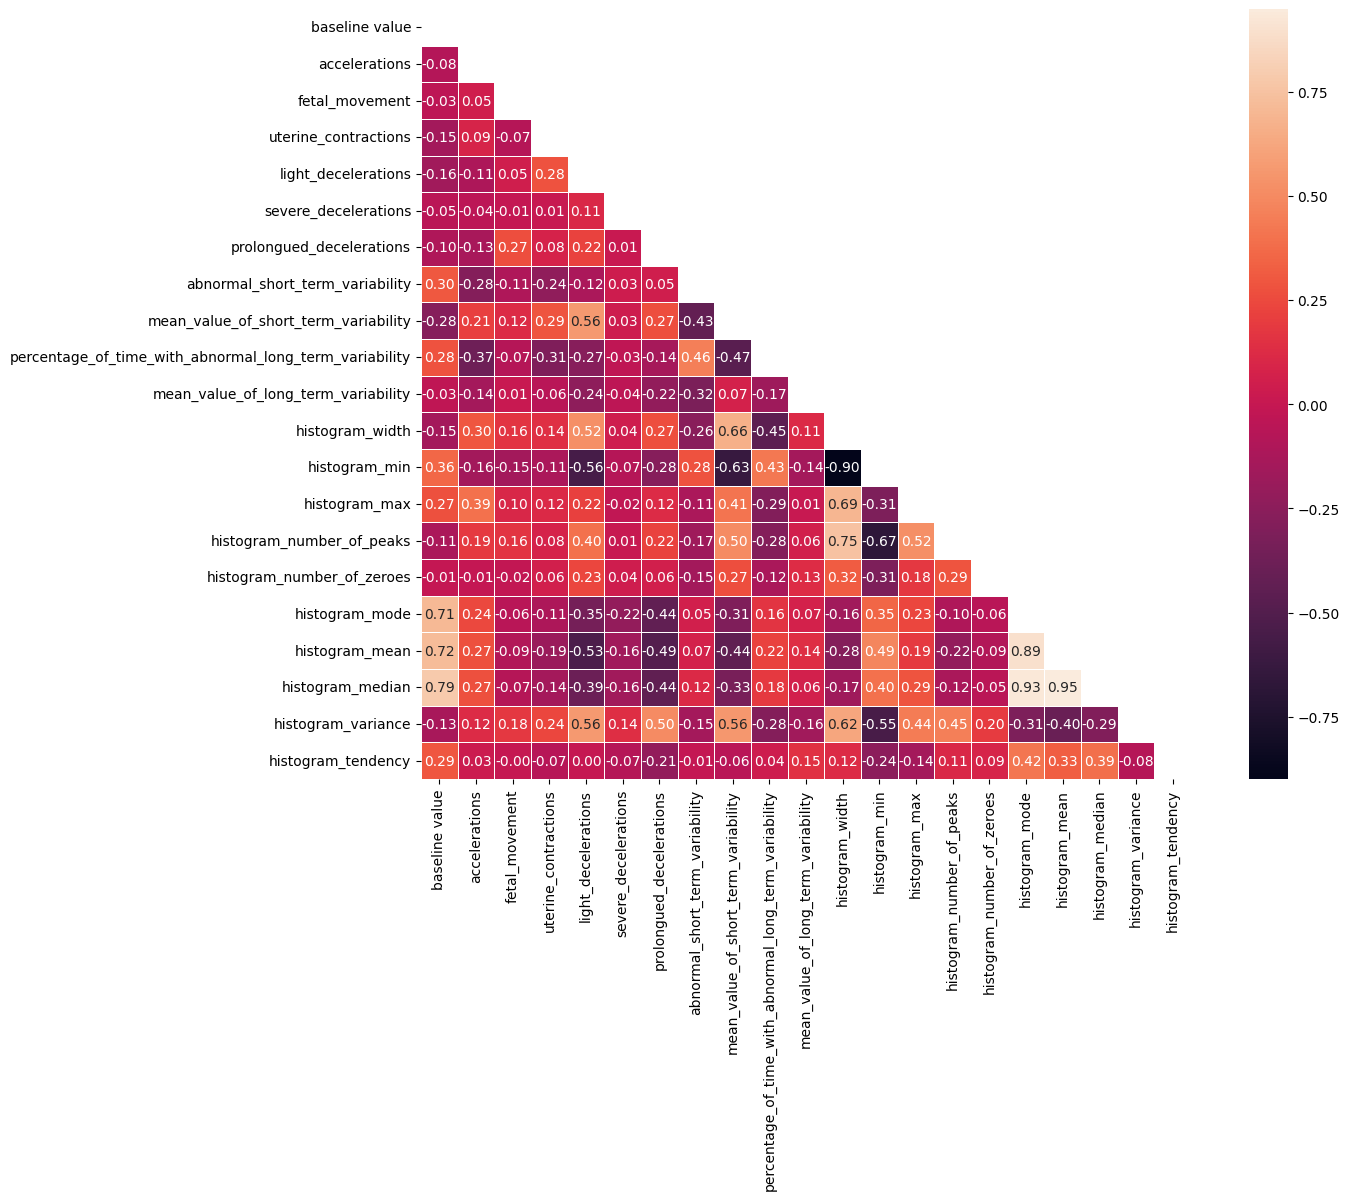

In [21]:
# Correlation check - among the features
mat = X_dropped.corr()
mask = np.triu(np.ones_like(mat, dtype=bool))
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(mat, mask=mask, annot = True, linewidths=0.5, fmt = ".2f", square=True)

We may need to apply **1) standardization** and **2) oversampling the minority** for better performance. We might be able to apply those methods one by one, but it will be better to streamline things into one pipeline.

(0.0, 22.0)

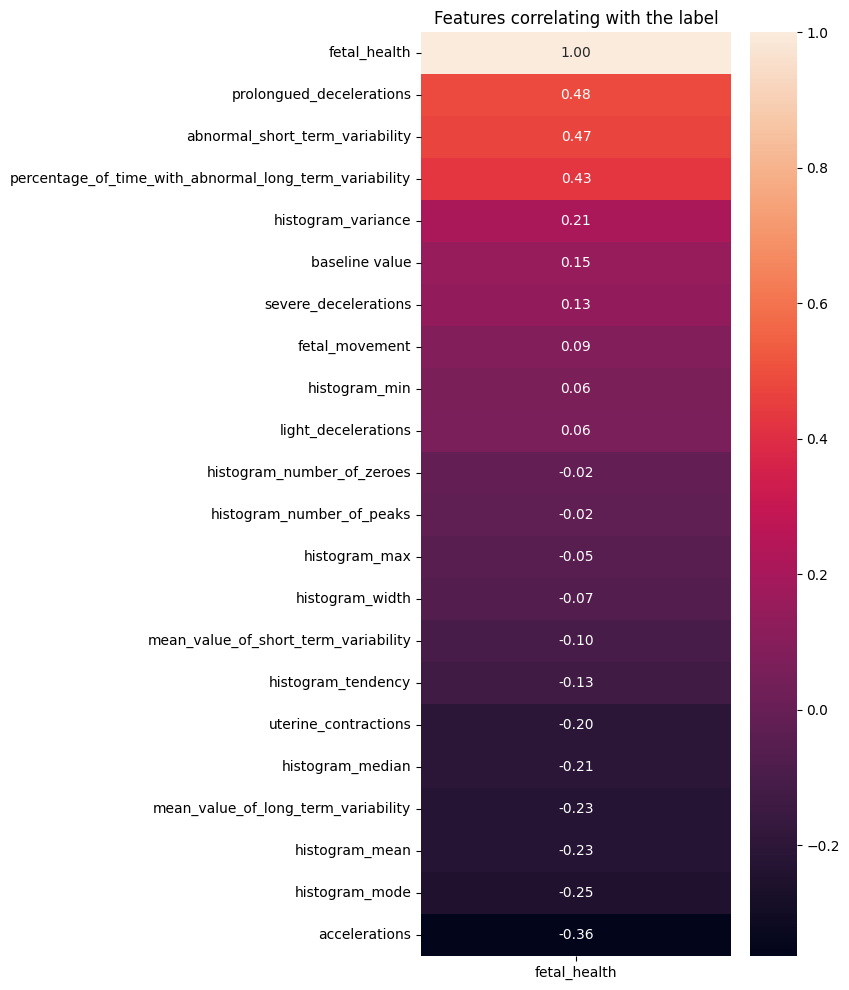

In [ ]:
# Correlation check - features and the label -> which features influence the outcome the most/the least
plt.figure(figsize=(5, 12))
heatmap = sns.heatmap(data.corr()[['fetal_health']].sort_values(by='fetal_health', ascending=True), fmt="0.2f", annot=True)
heatmap.set_title('Features correlating with the label')
heatmap.set_ylim([0,22])

### 2. Preprocessing

**Train test split**: After dividing the dataset into multiple parts, preprocessing like standardization or over-sampling should be applied. If not, we will end up with a cheating model that already knows part of the test information.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Create X_train, X_test, y_train, y_test using train_test_split with stratification. Set test size=0.3.
# stratification means that the proportion of labels in the training and test set is still the same
X_train, X_test, y_train, y_test = train_test_split(X_dropped, y_dropped, test_size=0.3, stratify=y_dropped)

**Standardization**: We can simply apply the standardization function we made in the previous lab or scikit-learn's method to standardize the dataset. This time, let's stick to scikit-learn. You can use scikit-learn's **StandardScaler** to apply standardization (= set the mean and the standard

In [ ]:
# StandardScaler
# X_train_scaled, X_test_scaled
# good comparison of StandardScaler and MinMaxScaler (see lecture 2 26/39)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X=X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = scaler.transform(X=X_test) # we don't fit the data which is to be predicted later by us with the model
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [26]:
# describe - standardized mean and standard deviation
X_train_scaled.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
count,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03,1477.000000,1.477000e+03,1.477000e+03,1.477000e+03,...,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03
mean,1.000629e-15,-2.236983e-16,-3.728305e-17,1.533416e-16,1.924286e-17,2.164822e-17,0.000000,-7.216074e-17,2.766162e-17,-1.202679e-17,...,-1.840099e-16,1.184639e-16,-1.852126e-16,-8.418753e-18,-7.937681e-17,6.783109e-16,-3.728305e-16,-3.559930e-16,3.968841e-17,9.861968e-17
std,1.000339e+00,1.000339e+00,1.000339e+00,1.000339e+00,1.000339e+00,1.000339e+00,1.000339,1.000339e+00,1.000339e+00,1.000339e+00,...,1.000339e+00,1.000339e+00,1.000339e+00,1.000339e+00,1.000339e+00,1.000339e+00,1.000339e+00,1.000339e+00,1.000339e+00,1.000339e+00
min,-2.777843e+00,-8.424830e-01,-2.063373e-01,-1.467429e+00,-6.463634e-01,-6.386594e-02,-0.265093,-2.008588e+00,-1.275732e+00,-5.225688e-01,...,-1.748667e+00,-1.446130e+00,-2.365226e+00,-1.396774e+00,-4.924607e-01,-4.715123e+00,-3.955050e+00,-4.135621e+00,-6.685203e-01,-2.183222e+00
25%,-7.420812e-01,-8.424830e-01,-2.063373e-01,-7.932790e-01,-6.463634e-01,-6.386594e-02,-0.265093,-8.498627e-01,-7.208534e-01,-5.225688e-01,...,-8.560916e-01,-9.060026e-01,-6.920163e-01,-7.291252e-01,-4.924607e-01,-5.176375e-01,-6.190407e-01,-6.257691e-01,-6.002941e-01,-5.354862e-01
50%,-2.956471e-02,-3.263704e-01,-2.063373e-01,-1.191288e-01,-6.463634e-01,-6.386594e-02,-0.265093,7.711761e-02,-1.659751e-01,-5.225688e-01,...,-4.002300e-02,-2.829544e-02,-1.342797e-01,-6.147615e-02,-4.924607e-01,9.069365e-02,8.665354e-02,6.243712e-02,-3.956153e-01,-5.354862e-01
75%,7.847399e-01,7.058547e-01,-1.436552e-01,5.550214e-01,3.599740e-01,-6.386594e-02,-0.265093,8.302891e-01,3.889032e-01,2.599845e-02,...,7.760456e-01,8.831697e-01,5.907778e-01,6.061729e-01,-4.924607e-01,6.381917e-01,6.640397e-01,6.818227e-01,1.843079e-01,1.112249e+00
max,2.718713e+00,4.060586e+00,9.843686e+00,3.588697e+00,4.385323e+00,1.565780e+01,7.926156,2.336632e+00,6.270613e+00,4.469393e+00,...,2.765213e+00,2.233488e+00,4.104518e+00,4.612067e+00,1.036373e+01,3.010683e+00,3.037739e+00,3.297006e+00,8.507912e+00,1.112249e+00


In [27]:
y_train.value_counts()

fetal_health
1    1151
2     204
3     122
Name: count, dtype: int64

**Oversampling**: To over-sample the instances from the minority classes (2 and 3), we will use a new library called **imblearn** (which stands for Imbalanced-(scikit)-learn). This library contains various classifiers and resampling methods for imbalanced datasets. Let's use the most straightforward method it has.

In [28]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Define RandomOverSampler to a variable ros
# The RandomOverSampler evens out disbalances in the data (see lecture 2 30/39)
# ratio
ros = RandomOverSampler(random_state=12345) # random seed
# Create X_resampled, y_resampled using the fit_resample method or fit + sample.
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train)

In [30]:
# value_counts
y_train_resampled.value_counts()

fetal_health
1    1151
2    1151
3    1151
Name: count, dtype: int64

Unfortunately, this simple oversampler just duplicates the instances we already have. So we can regard that it's just a weighting factor putting more weights on the minority classes.

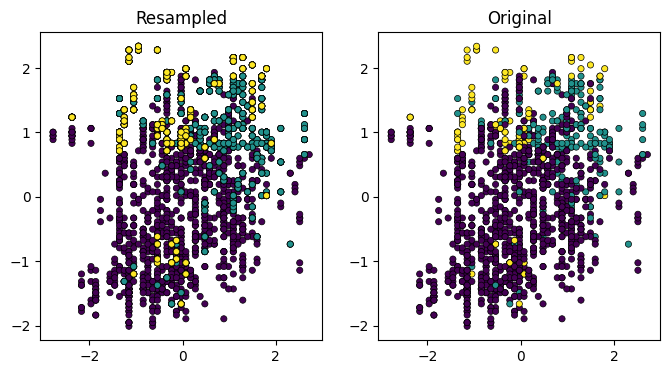

In [ ]:
# We now have an equal balance for all the classes. The statement above is a great point
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
ax[0].scatter(X_train_resampled.iloc[:, 0], X_train_resampled.iloc[:, 7], c=y_train_resampled, s=20, linewidth=0.5, edgecolor='black')
ax[1].scatter(X_train_scaled.iloc[:, 0], X_train_scaled.iloc[:, 7], c=y_train, s=20, linewidth=0.5, edgecolor='black')
ax[0].set_title("Resampled")
ax[1].set_title("Original")
plt.show()

There are some more advanced techniques to resample such as **SMOTE** or **ADASYN**...

- [What does SMOTE do?](https://www.researchgate.net/publication/287601878/figure/fig1/AS:316826589384744@1452548753581/The-schematic-of-NRSBoundary-SMOTE-algorithm.png)
- [What do the others do?](https://www.kaggle.com/code/residentmario/oversampling-with-smote-and-adasyn)
- [EasyEnsemble and BalanceCascade](https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data/notebook)
- [SMOTE variants](https://imbalanced-learn.org/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html#sphx-glr-auto-examples-over-sampling-plot-comparison-over-sampling-py)

In [32]:
from imblearn.over_sampling import SMOTE, ADASYN

In [ ]:
# With these techniques we want to balance our data sets through oversampling or undersampling
# SMOTE, ADASYN
# SMOTE is weak when we have a few outliers that do not contribute the classification performance.
# They add data to the minorities
# X_resampled_SMOTE, y_resampled_SMOTE
X_resampled_SMOTE, y_resampled_SMOTE = SMOTE().fit_resample(X_train_scaled, y_train)
# X_resampled_ADASYN, y_resampled_ADASYN
X_resampled_ADASYN, y_resampled_ADASYN = ADASYN().fit_resample(X_train_scaled, y_train)

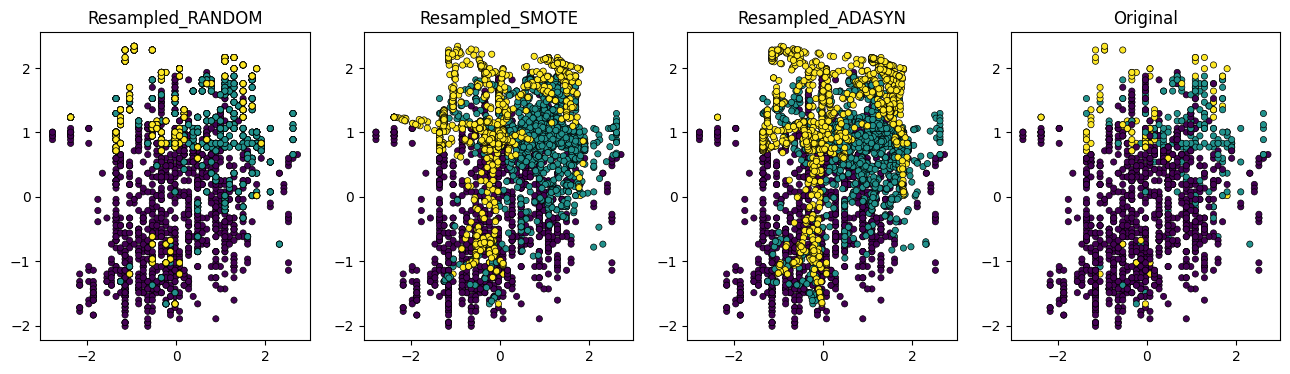

In [ ]:
# if I understand correctly, we just take 2 out of those 21 features and plot them respectively to see
# how each resample technique worked
fig, ax = plt.subplots(1, 4, figsize=[16, 4])
ax[0].scatter(X_train_resampled.iloc[:, 0], X_train_resampled.iloc[:, 7], c=y_train_resampled, s=20, linewidth=0.5, edgecolor='black')
ax[1].scatter(X_resampled_SMOTE.iloc[:, 0], X_resampled_SMOTE.iloc[:, 7], c=y_resampled_SMOTE, s=20, linewidth=0.5, edgecolor='black')
ax[2].scatter(X_resampled_ADASYN.iloc[:, 0], X_resampled_ADASYN.iloc[:, 7], c=y_resampled_ADASYN, s=20, linewidth=0.5, edgecolor='black')
ax[3].scatter(X_train_scaled.iloc[:, 0], X_train_scaled.iloc[:, 7], c=y_train, s=20, linewidth=0.5, edgecolor='black')
ax[0].set_title("Resampled_RANDOM")
ax[1].set_title("Resampled_SMOTE")
ax[2].set_title("Resampled_ADASYN")
ax[3].set_title("Original")

plt.show()

Sometimes there have been some practices to keep the minority classes at most 50% of the majority (so in our case, classes 2 and 3 won't have more than 827 instances).

### 3. Simple ensemble

A simple ensemble model with a hard voting / soft voting can be created using scikit-learn's `VotingClassifier`.

In [35]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [36]:
dt = DecisionTreeClassifier()
lr = LogisticRegression()
svm = SVC()

In [ ]:
voting = VotingClassifier([('lr', lr), ('dt', dt), ('svm', svm)], voting='hard')
voting

In [ ]:
# fit the method on X_train_scaled and y_train
voting.fit(X_train_scaled, y_train)

Check the scores of each method and the voting classifier.

In [ ]:
for clf in (dt, lr, svm, voting):
  clf.fit(X_resampled_SMOTE, y_resampled_SMOTE)
  print(clf.__class__.__name__, clf.score(X_test_scaled, y_test))

In [ ]:
for clf in (dt, lr, svm, voting):
  clf.fit(X_resampled_ADASYN, y_resampled_ADASYN)
  print(clf.__class__.__name__, clf.score(X_test_scaled, y_test))

In [ ]:
for clf in (dt, lr, svm, voting):
  clf.fit(X_train_scaled, y_train)
  print(clf.__class__.__name__, clf.score(X_test_scaled, y_test))

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_pred = voting.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

Those are our basic performance scores.

### 4. Practical ensemble methods

We may use some ensemble methods that were covered in the lecture. To just use those models, we can still stick to the standard scikit-learn process. Random forests and AdaBoost are supported by scikit-learn. However, you need a separate library for XGBoost.

#### Bagging

`BaggingClassifier` supports the following modes:
 - For samples: bagging, pasting (without replacement)
 - For features: Random patches (sampling both samples and features), random subspaces (sampling only features)


In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
# max_features, bootstrap_features
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 500, bootstrap = True, n_jobs = -1)
bag_clf.fit(X_train_scaled, y_train)
bag_clf.score(X_test_scaled, y_test)

**Out-of-bag evaluation**: Average the scores using the out of bag samples. To use the oob_score, you need to turn it on when you initialize the classifier.

In [ ]:
#oob_score = True
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 500, bootstrap = True, n_jobs = -1, oob_score=True)
bag_clf.fit(X_train_scaled, y_train)
bag_clf.score(X_test_scaled, y_test)

In [ ]:
# After training, you can check the score from oob_score_.
bag_clf.oob_score_

In [ ]:
# oob_decision_function_ will show the probabilities for each oob instance
bag_clf.oob_decision_function_

#### Random forests = Decision tree trained via bagging

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)
rf.score(X_test_scaled, y_test)

Also check: [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)

#### AdaBoost (Adaptive Boosting) - Various classifiers / IT CANNOT BE PARALLELIZED

AdaBoost is a normal boosting algorithm, creating multiple weak learners throughout multiple phases - so each phase is dependent on the previous one. Since the weight can be applied to any classifier, you can change the base classifier as you want.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
# AdaBoostClasifier
# - base_estimator -> default estimator is Decision Stump
ab = AdaBoostClassifier()
ab.fit(X_train_scaled, y_train)
print(ab.score(X_test_scaled, y_test))

In [ ]:
# - base_estimator = LogisticRegression()
ab = AdaBoostClassifier(estimator=LogisticRegression())
ab.fit(X_train_scaled, y_train)
print(ab.score(X_test_scaled, y_test))

#### XGBoost (Gradient Boosting) - IT CAN BE PARALLELIZED

XGBoost is a decision-tree-based gradient boosting classifier with more advanced tricks inside to make itself a more scalable and better performance. The key differences are as follows:

 - An improved data structure for better utilization such as sparse matrices
 - Better support for multicore processing.
 - L1/L2 regularization
 - Tree-node dropout


 To best exploit XGBoost, you need to perform [parameter optimization](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).

In [ ]:
# - XGBoost
import xgboost as xgb

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode the labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Then train the model
xgbm = xgb.XGBClassifier()
xgbm.fit(X_train_scaled, y_train_encoded)
print(xgbm.score(X_test_scaled, y_test_encoded))

XGBoost also supports to handle imbalanced datasets by putting different weights based on the class distribution. For more details, [check this article](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

 - scale_pos_weight with GridSearchCV


### 5. Grid search and Randomized search

#### Grid search

Grid search is a method of tuning the optimal hyperparameter value by trying all possible combinations of the parameters of interest, provided by scikit-learn of python. Grid search has the disadvantage of being very expensive and time-consuming to calculate because it evaluates all combinations.

#### Randomized search

Randomized search finds optimal hyperparameter values by generating random numbers within a specified range. Hyperparameters are of different relative importance, and random searches are advantageous for optimization because more important parameters can be explored. In fact, there are also indicators that random searches in papers yield better results with fewer search opportunities. Random Search can stop searching at any time. This is because even if you stop in the middle, the search is not biased towards a specific range.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Our parameter distribution (or parameter grid in the case of grid search)
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Compared to the grid search, the randomized search has some randomness and iterations, so it has a few more parameters such as **n_iter**, **random_state**. Also, the parameter grid is now called parameter distributions as it can also receive a distribution (such as **scipy.stats.uniform**) and sample from it.

In [ ]:
# RandomizedSearchCV - create the randomized search instance with those parameters
# - estimator: random forest
# - param_distribution: random_grid
# - n_iter: 100
# - cv: 3

# We also have those optional parameters
# - random_state
# - refit (default = True)

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)

In [ ]:
%%time
rf_random.fit(X_train_scaled, y_train)

In [ ]:
# best_estimator
rf_random.best_estimator_

In [ ]:
# best_score
rf_random.best_score_

In [ ]:
# test score
rf_random.score(X_test_scaled, y_test)

You can also run a grid search and see if it completes in a reasonable amount of time.

In [ ]:
gs_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=2, n_jobs = -1)

In [ ]:
%%time
gs_random.fit(X_train_scaled, y_train) # NEVER FINISHES!!!!!

Randomized search is greatly helpful when we have many options to search as it randomly choose the combination. However, it does not guarantee that it will find the optimal solution, but still it will give you similar result with the grid search. However, if you only have a limited number of parameter combinations, it is still the best to apply the grid search.

### 6. Pipelines

Most machine learning data is not ideal for building a final model. Many data transformations such as manipulating categorical variables or scaling and normalization must be performed. Scikit-Learn has built-in most commonly used functions for preprocessing functions. However, in a typical machine learning workflow, you would need to apply all these transformations more than once. Because you do it once when you train the model and again for every new data you want to predict. Of course, you can use a reusable function, but you will have to run it first and then call the model separately. The Scikit-Learn pipeline is a tool that simplifies this process and has several key advantages:

- Pipelines allow you to create a single object that contains all stages of data preprocessing and classification.
- It makes cross-validation and other types of model selection easier.
- Increased reproducibility

Using pipeline lets you manage your whole preprocessing and training process in one place and change the setting in a central place.
- [Advanced pipeline tutorial and parameter tuning](https://towardsdatascience.com/advanced-pipelines-with-scikit-learn-4204bb71019b)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# Create a pipeline
# - featureGenerator = PolynomialFeatures
# - scaler = StandardScaler
# - selector = VarianceThreshold with 0.1
# - classifier = RandomForestClassifier
# etc: LabelEncoder ... OneHotEncoder ... KBinsDiscretizer ... SimpleImputer

pipe = Pipeline([
  ('featureGenerator', PolynomialFeatures()),
  ('scaler', StandardScaler()),
  ('selector', VarianceThreshold(0.1)),
  ('classifier', RandomForestClassifier())
])





We can fit the pipeline in the same way as general scikit-learn classifiers.

In [ ]:
pipe.fit(X_train_scaled, y_train)

In [ ]:
print('Training set score: ' + str(pipe.score(X_train_scaled, y_train)))
print('Test set score: ' + str(pipe.score(X_test_scaled, y_test)))

---

<span style="color:red"><b>TASK 1</b> - Add private functions to pipelines:</span>

---
Most of the functions are supported by scikit-learn, but sometimes you may need other methods as well to change the dataset. In this case, you may have some modules that are not part of the pipeline. However, the scikit-learn pipeline also supports custom functions following some rules.

The rule here is to construct a class with both fit and transform methods inside.



- Create a class `SquaredFeatureTransformer` that squares the values in a numpy array and merges those squared features into the original array (i.e., the number of features is doubled). Note that we assume the dataset is in a tabular format, which means columns would be features, while rows would be instances.
- Our dataset will have two times more features after this transformation.
- Integrate this transformer into the pipeline, by adding the class `SquaredFeatureTransformer` with the name `squared`. The whole pipeline structure should be as follows:
  - scaler = StandardScaler
  - squared = SquaredFeatureTransformer
  - selector = VarianceThreshold with 0.1 variance threshold
  - classifier = RandomForestClassifier
- Eventually, the pipeline should have four elements: `scaler`, `squared`, `selector`, and `classifier`. Define this pipeline to the variable pipe.
- Understand how to create a custom transformer function.

Please note that in the grading system on nextilearn, all necessary libraries are already imported. Do not import any libraries.

In [ ]:
class SquaredFeatureTransformer(BaseEstimator, TransformerMixin):
  #This class will transform the dataset by adding squared features
  #You need to change the transform function to square each feature's values and add them to the matrix.

  def __init__(self):
    return None

  def fit(self, X, y = None):
    return None

  def transform(self, X, y = None):
    return None

pipe = None # CHANGE IT

---

<span style="color:red"><b>TASK 2</b> - Integrate grid search into pipelines:</span>

---
So far, we have learned randomized search and grid search for a parameter search of a specific model and the scikit-learn pipeline to streamline the complete machine learning task from preprocessing to model training. Then the remaining question is how we can also integrate the model selection process - like the parameter search we performed using the grid search and the randomized search - into the pipeline.

By adding those parameter tests, you can also change the modules that should be in the same name: for example, you can have `[StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler()]` in a name 'scaler' of the pipeline. Moreover, you can perform a grid test if they have the common parameters - they usually have.

Define a new variable parameters and customize the options by creating a dictionary. You can change the pipeline values by setting the same key as you did for the pipeline. For example, if you would like to test two scalers, you can put 'scaler': [scaler1, scaler2].

Create the following key-values in the parameters dictionary.

 - scaler: `[StandardScaler(), MinMaxScaler()]`.
 - classifier: `[AdaBoostClassifier(), RandomForestClassifier()]`.

You can also search for many parameter options by using underscores. Please check this guideline. If you want to test the threshold parameter of the selector (here, we use `VarianceThreshold` as a selector).

Your parameter grid should also have a threshold for `VarianceThreshold` with the values `[0, 0.001, 0.01]`.

Define a grid search with cross validation into the variable grid_search. You can put the predefined pipeline instance pipe as a classifier and should use your parameter grid. The search should run 5-fold cross validation.

In [ ]:
# Define the parameter grid
parameters = None # CHANGE IT

# Run grid search
grid_search = None # CHANGE IT

---

<span style="color:red"><b>TASK 3</b> - Nested k-fold cross validation:</span>

---

In this exercise, you will implement nested k-fold cross-validation using Scikit-Learn to evaluate and compare different machine learning models while tuning their hyperparameters. The goal is to perform model selection in a robust and unbiased manner, ensuring that hyperparameter tuning and model evaluation are conducted on separate data splits. You will work with the breast_cancer dataset from sklearn.datasets, where the objective is to classify whether a tumor is malignant or benign. Please check this guideline to see how to open the dataset.

You will define a pipeline that includes a scaler (`StandardScaler`), a feature selector (`VarianceThreshold`), and a classifier. Two classifiers will be tested: `RandomForestClassifier` and `AdaBoostClassifier`. Each classifier will have a specific set of hyperparameters to tune:

- **RandomForestClassifier parameters**:
  - `n_estimators: [50, 100]`
  - `max_depth: [None, 10]`
- **AdaBoostClassifier parameters**:
  - `n_estimators: [50, 100]`
  - `learning_rate: [0.01, 0.1]`

You may create a dictionary called `param_grids` having two keys `'RandomForest', 'AdaBoost'` where each has a parameter grid for each classifier as a value. Then you will apply nested cross-validation with:

Outer loop (2-fold stratified cross-validation): Splits the dataset into 2 folds, where 1 fold is used as the test set and the remaining 4 folds are used for training. For this instance, set the random state to 42 and shuffle the dataset.
Inner loop (2-fold stratified cross-validation using `GridSearchCV`): Finds the best hyperparameters for each classifier on the training set of the outer loop. For this instance, set the random state to 42 and shuffle the dataset.

For each outer loop iteration, fit the best model (determined by `GridSearchCV`) on the training data and evaluate it on the outer test set. At the end, compute the mean accuracy across all outer folds to compare the models. The classifier with the highest mean accuracy across the outer folds is considered the best model for this dataset. Save the final accuracy value into the variable final_accuracy in the format of dictionary with two keys: `'RandomForest', 'AdaBoost'`. For validation, make sure to set the random state of `RandomForestClassifier` and `AdaBoostClassifier` to 42.

Note that while we provide you with skeleton code, you are free to implement in your own preferred way. We will only validate the `final_score` dictionary if the average performance is correct.